## Argo Multiple Regions Test

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import argopy
import scipy.ndimage as filter
filter.gaussian_filter1d
import cartopy.crs as ccrs
import cartopy

## Useful Functions

In [3]:
#NOTE: choosing higer depth_max values will limit the number of profiles returned
def get_ds_interp(ds,depth_min,depth_max,sample_max):
    median_dp=ds.PRES.where(ds.PRES<depth_max).where(ds.PRES>depth_min).diff('N_LEVELS').median('N_LEVELS')
    ind_rate=median_dp.where(median_dp<sample_max,drop=True).N_PROF
    ds_sel=ds.sel(N_PROF=ind_rate)
    ds_interp=ds_sel.argo.interp_std_levels(np.arange(depth_min,depth_max,2))
    ds_interp=ds_interp.sortby(ds_interp.N_PROF)
    return ds_interp.TEMP

In [4]:
def get_ds_filt(ds_interp,first,last,num):
    sigmas=np.logspace(first,last,num)
    temp=np.zeros((ds_interp.N_PROF.shape[0],ds_interp.PRES_INTERPOLATED.shape[0],num))

    for n in range(0,num):
        temp[:,:,n]=filter.gaussian_filter1d(ds_interp,sigma=sigmas[n],mode='nearest')

    ds_filt=xr.DataArray(temp,dims=['N_PROF','PRES_INTERPOLATED','FILT_SCALE'],
             coords={'N_PROF':ds_interp.N_PROF,'PRES_INTERPOLATED':ds_interp.PRES_INTERPOLATED,'FILT_SCALE':sigmas})
    return ds_filt

In [5]:
def get_var(ds_interp,ds_filt):
    var=np.zeros(len(ds_filt.FILT_SCALE))
    for n,sig in enumerate(so_filt.FILT_SCALE):
        prof=ds_filt.sel(FILT_SCALE=sig)
        var[n]=(prof-ds_interp).var()
    return var

In [6]:
def get_2_depths(ds,first,mid,last,sample_max):
    interp_1=get_ds_interp(ds,first,mid,sample_max)
    interp_2=get_ds_interp(ds,mid,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    
    return filt_1,var_1,filt_2,var_2

In [7]:
def get_3_depths(ds,first,mid1,mid2,last,sample_max):
    interp_1=get_ds_interp(ds,first,mid1,sample_max)
    interp_2=get_ds_interp(ds,mid1,mid2,sample_max)
    interp_3=get_ds_interp(ds,mid2,last,sample_max)
    
    filt_1=get_ds_filt(interp_1,0.5,2.5,50)
    filt_2=get_ds_filt(interp_2,0.5,2.5,50)
    filt_3=get_ds_filt(interp_3,0.5,2.5,50)
    
    var_1=get_var(interp_1,filt_1)
    var_2=get_var(interp_2,filt_2)
    var_3=get_var(interp_3,filt_3)
    
    return filt_1,var_1,filt_2,var_2,filt_3,var_3

## Define Regions

In [8]:
#Southern Ocean, south of Africa
so_param=[30,40,-55,-50,0,2000]
so_ds=xr.open_dataset("202206_lon:(30,40)_lat:(-55,-50).nc")
so_coords=np.array([[so_param[0],so_param[1]],[so_param[2],so_param[3]]])

In [9]:
#North Pacific
np_param=[-155,-145,30,35,0,2000]
np_ds=xr.open_dataset("202206_lon:(-155,-145)_lat:(30,35).nc")

In [10]:
#North Atlantic
na_param=[-55,-45,40,45,0,2000]
na_ds=xr.open_dataset("202206_lon:(-55,-45)_lat:(40,45).nc")

In [11]:
#Indian Ocean
io_param=[90,100,-15,-10,0,2000]
io_ds=xr.open_dataset("202206_lon:(90,100)_lat:(-15,-10).nc")

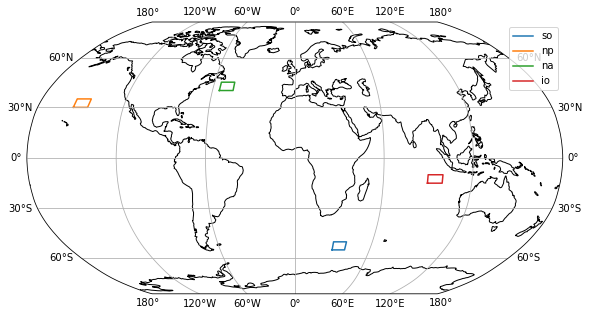

In [12]:
plt.figure(figsize=(12,5))
ax=plt.axes(projection=ccrs.Robinson())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.plot((so_param[0],so_param[1],so_param[1],so_param[0],so_param[0]), (so_param[2],so_param[2],so_param[3],so_param[3],so_param[2]),transform=ccrs.PlateCarree(),label='so')
plt.plot((np_param[0],np_param[1],np_param[1],np_param[0],np_param[0]), (np_param[2],np_param[2],np_param[3],np_param[3],np_param[2]),transform=ccrs.PlateCarree(),label='np')
plt.plot((na_param[0],na_param[1],na_param[1],na_param[0],na_param[0]), (na_param[2],na_param[2],na_param[3],na_param[3],na_param[2]),transform=ccrs.PlateCarree(),label='na')
plt.plot((io_param[0],io_param[1],io_param[1],io_param[0],io_param[0]), (io_param[2],io_param[2],io_param[3],io_param[3],io_param[2]),transform=ccrs.PlateCarree(),label='io')
plt.legend()

In [13]:
so_interp=get_ds_interp(so_ds,0,2000,3)
np_interp=get_ds_interp(np_ds,0,2000,3)
na_interp=get_ds_interp(na_ds,0,2000,3)
io_interp=get_ds_interp(io_ds,0,2000,3)

In [14]:
so_filt=get_ds_filt(so_interp,0.5,2.5,50)
np_filt=get_ds_filt(np_interp,0.5,2.5,50)
na_filt=get_ds_filt(na_interp,0.5,2.5,50)
io_filt=get_ds_filt(io_interp,0.5,2.5,50)

In [15]:
so_var=get_var(so_interp,so_filt)
np_var=get_var(np_interp,np_filt)
na_var=get_var(na_interp,na_filt)
io_var=get_var(io_interp,io_filt)

## Anomaly and Filter Scale Plots

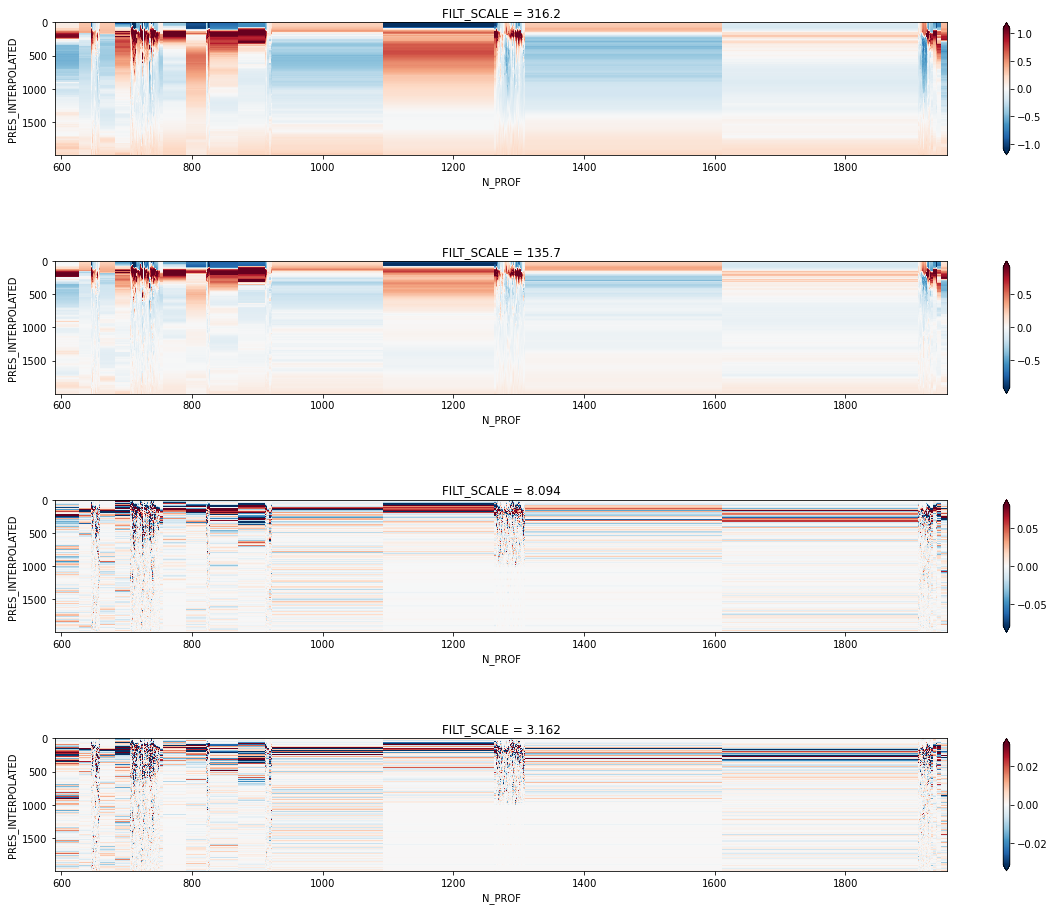

In [29]:
plt.figure(figsize=(20,20))
so_scales=[so_filt.FILT_SCALE[-1],so_filt.FILT_SCALE[-10],so_filt.FILT_SCALE[10],so_filt.FILT_SCALE[0]]
np_scales=[np_filt.FILT_SCALE[-1],np_filt.FILT_SCALE[-10],np_filt.FILT_SCALE[10],np_filt.FILT_SCALE[0]]
na_scales=[na_filt.FILT_SCALE[-1],na_filt.FILT_SCALE[-10],na_filt.FILT_SCALE[10],na_filt.FILT_SCALE[0]]
io_scales=[io_filt.FILT_SCALE[-1],io_filt.FILT_SCALE[-10],io_filt.FILT_SCALE[10],io_filt.FILT_SCALE[0]]

for n,sig in enumerate(so_scales):
    filt=so_filt.sel(FILT_SCALE=sig)
    anom=filt-so_interp
    plt.subplot(5,1,n+1)
    anom.plot(y='PRES_INTERPOLATED',robust=True)
    plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0.8)

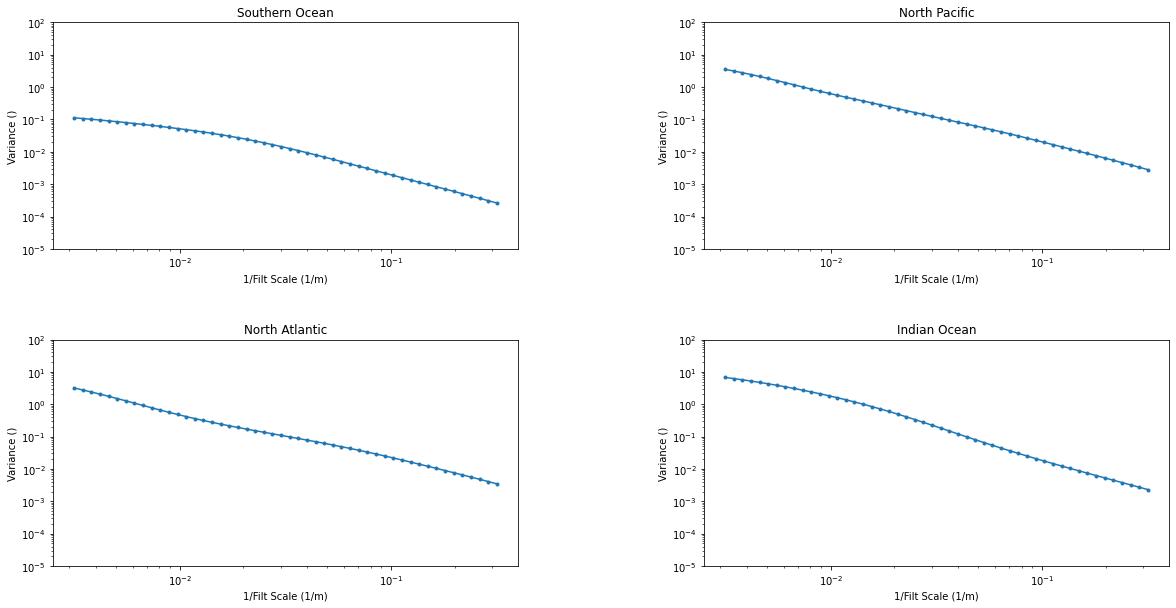

In [17]:
plt.figure(figsize=(20,10))
xs=[1/so_filt.FILT_SCALE,1/np_filt.FILT_SCALE,1/na_filt.FILT_SCALE,1/io_filt.FILT_SCALE]
ys=[so_var,np_var,na_var,io_var]
titles=['Southern Ocean','North Pacific','North Atlantic','Indian Ocean']

for n in range(0,4):
    plt.subplot(2,2,n+1)
    plt.plot(xs[n],ys[n],'.-')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("1/Filt Scale (1/m)")
    plt.ylabel("Variance ()")
    plt.ylim(10**-5,10**2)
    plt.title(titles[n])

plt.subplots_adjust(hspace=0.4,wspace=0.4)

## Filter Plots with Depth Bins

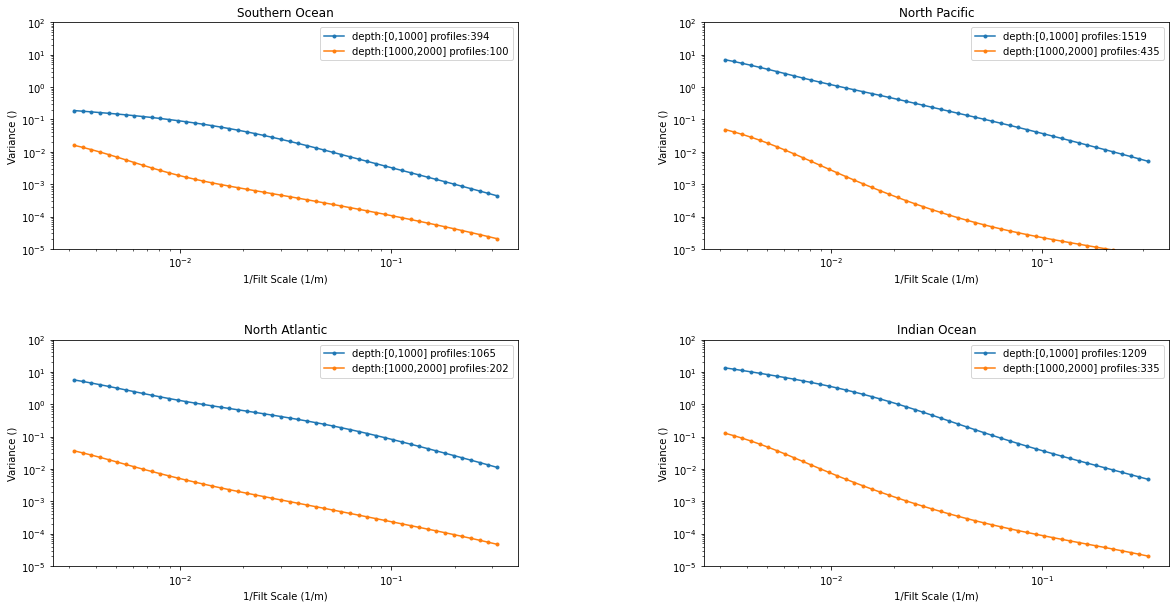

In [18]:
plt.figure(figsize=(20,10))
first,mid,last,sample_max=0,1000,2000,3
so_filt_1,so_var_1,so_filt_2,so_var_2=get_2_depths(so_ds,first,mid,last,sample_max)
np_filt_1,np_var_1,np_filt_2,np_var_2=get_2_depths(np_ds,first,mid,last,sample_max)
na_filt_1,na_var_1,na_filt_2,na_var_2=get_2_depths(na_ds,first,mid,last,sample_max)
io_filt_1,io_var_1,io_filt_2,io_var_2=get_2_depths(io_ds,first,mid,last,sample_max)

x1s=[1/so_filt_1.FILT_SCALE,1/np_filt_1.FILT_SCALE,1/na_filt_1.FILT_SCALE,1/io_filt_1.FILT_SCALE]
x2s=[1/so_filt_2.FILT_SCALE,1/np_filt_2.FILT_SCALE,1/na_filt_2.FILT_SCALE,1/io_filt_2.FILT_SCALE]
y1s=[so_var_1,np_var_1,na_var_1,io_var_1]
y2s=[so_var_2,np_var_2,na_var_2,io_var_2]
label1=[so_filt_1.N_PROF.shape[0],np_filt_1.N_PROF.shape[0],na_filt_1.N_PROF.shape[0],io_filt_1.N_PROF.shape[0]]
label2=[so_filt_2.N_PROF.shape[0],np_filt_2.N_PROF.shape[0],na_filt_2.N_PROF.shape[0],io_filt_2.N_PROF.shape[0]]
titles=['Southern Ocean','North Pacific','North Atlantic','Indian Ocean']

for n in range(0,4):
    plt.subplot(2,2,n+1)
    plt.plot(x1s[n],y1s[n],'.-',label='depth:[{},{}] profiles:{}'.format(first,mid,label1[n]))
    plt.plot(x2s[n],y2s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid,last,label2[n]))
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("1/Filt Scale (1/m)")
    plt.ylabel("Variance ()")
    plt.ylim(10**-5,10**2)
    plt.title(titles[n])

plt.subplots_adjust(hspace=0.4,wspace=0.4)

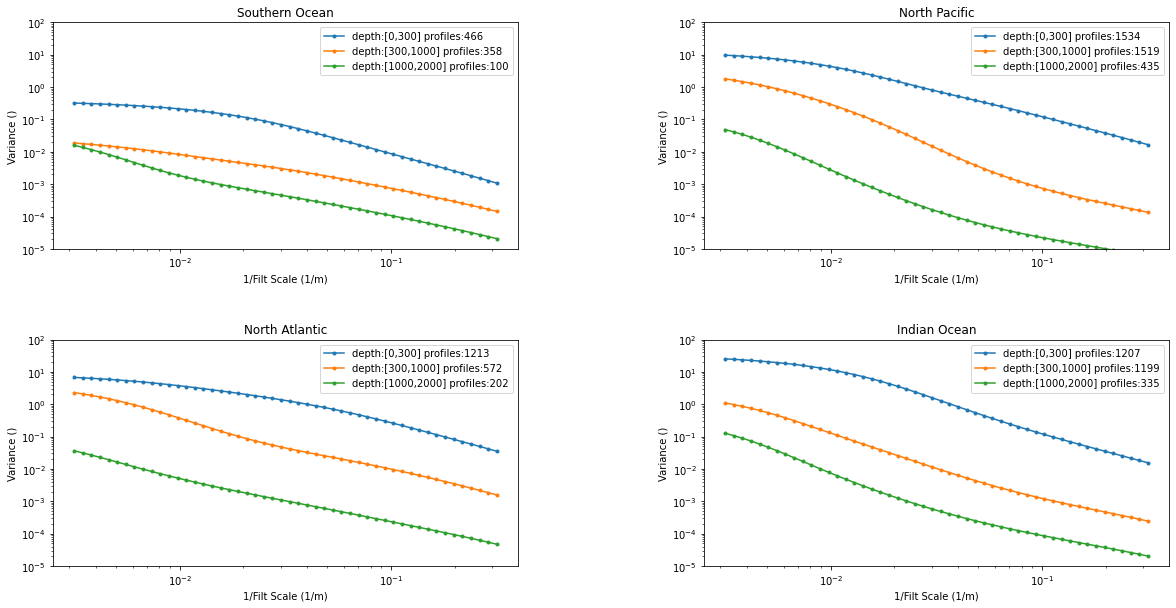

In [28]:
plt.figure(figsize=(20,10))
first,mid1,mid2,last,sample_max=0,300,1000,2000,3
so_filt_1,so_var_1,so_filt_2,so_var_2,so_filt_3,so_var_3=get_3_depths(so_ds,first,mid1,mid2,last,sample_max)
np_filt_1,np_var_1,np_filt_2,np_var_2,np_filt_3,np_var_3=get_3_depths(np_ds,first,mid1,mid2,last,sample_max)
na_filt_1,na_var_1,na_filt_2,na_var_2,na_filt_3,na_var_3=get_3_depths(na_ds,first,mid1,mid2,last,sample_max)
io_filt_1,io_var_1,io_filt_2,io_var_2,io_filt_3,io_var_3=get_3_depths(io_ds,first,mid1,mid2,last,sample_max)

x1s=[1/so_filt_1.FILT_SCALE,1/np_filt_1.FILT_SCALE,1/na_filt_1.FILT_SCALE,1/io_filt_1.FILT_SCALE]
x2s=[1/so_filt_2.FILT_SCALE,1/np_filt_2.FILT_SCALE,1/na_filt_2.FILT_SCALE,1/io_filt_2.FILT_SCALE]
x3s=[1/so_filt_3.FILT_SCALE,1/np_filt_3.FILT_SCALE,1/na_filt_3.FILT_SCALE,1/io_filt_3.FILT_SCALE]
y1s=[so_var_1,np_var_1,na_var_1,io_var_1]
y2s=[so_var_2,np_var_2,na_var_2,io_var_2]
y3s=[so_var_3,np_var_3,na_var_3,io_var_3]
label1=[so_filt_1.N_PROF.shape[0],np_filt_1.N_PROF.shape[0],na_filt_1.N_PROF.shape[0],io_filt_1.N_PROF.shape[0]]
label2=[so_filt_2.N_PROF.shape[0],np_filt_2.N_PROF.shape[0],na_filt_2.N_PROF.shape[0],io_filt_2.N_PROF.shape[0]]
label3=[so_filt_3.N_PROF.shape[0],np_filt_3.N_PROF.shape[0],na_filt_3.N_PROF.shape[0],io_filt_3.N_PROF.shape[0]]
titles=['Southern Ocean','North Pacific','North Atlantic','Indian Ocean']

for n in range(0,4):
    plt.subplot(2,2,n+1)
    plt.plot(x1s[n],y1s[n],'.-',label='depth:[{},{}] profiles:{}'.format(first,mid1,label1[n]))
    plt.plot(x2s[n],y2s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid1,mid2,label2[n]))
    plt.plot(x3s[n],y3s[n],'.-',label='depth:[{},{}] profiles:{}'.format(mid2,last,label3[n]))
    plt.legend()
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("1/Filt Scale (1/m)")
    plt.ylabel("Variance ()")
    plt.ylim(10**-5,10**2)
    plt.title(titles[n])

plt.subplots_adjust(hspace=0.4,wspace=0.4)